## This notebook creates the network analyses and associated figures:
### Figure 6, Supplementary Figures 21-28, and Supplementary Tables 8-10

## Objective: Determine which fungal and bacterial taxa are co-associated
Determine which plant and microbial taxa are co-associated  
Assumption: The same taxa will follow the same patterns across all samples (hence, use all samples)

In [1]:
# Loading required packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
library(vegan)
library(ade4)
library(wesanderson)
library(igraph)
library(tidyr)
library(threejs)
library(htmlwidgets)
library(RColorBrewer)


Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-4

Attaching package: ‘igraph’

The following object is masked from ‘package:vegan’:

    diversity

The following object is masked from ‘package:permute’:

    permute

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    unio

## First goal is merging the fungal and bacterial phyloseq objects

In [2]:
bact_offset = 2
fung_offset = 4

In [3]:
ps.f = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps.f.norm = transform_sample_counts(ps.f, function(x) (x / sum(x)))
ps.f.norm = transform_sample_counts(ps.f.norm, function(x) x+fung_offset)
# We adding a count of 4 to the normalized data in order to
# offset it from the bacterial taxa - because they were sequenced separately,
# changes in the rank of fungi should not affect changes in the rank of bacteria, and vice versa
# This approach will keep them separated when we combine the datastes, and won't affect the Spearman ranking
# Obviously this wouldn't work if certain other metrics other than Spearman were used.
ps.f.norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5938 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 5938 taxa by 16 taxonomic ranks ]

In [4]:
# Bringing in the bacterial data

ps.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
ps.m.norm = transform_sample_counts(ps.m, function(x) (x / sum(x)))
ps.m.norm = transform_sample_counts(ps.m.norm, function(x) x+bact_offset)
# Adding 2 for different dataset offset - won't affect Spearman ranking - as above
ps.m.norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19988 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 19988 taxa by 7 taxonomic ranks ]

In [5]:
# Getting only shared samples between fung and bact
ps.m.shared = subset_samples(ps.m.norm,sample_names(ps.m.norm) %in% sample_names(ps.f.norm))
ps.f.shared = subset_samples(ps.f.norm,sample_names(ps.m.norm) %in% sample_names(ps.m.norm))

In [6]:
# Merging the two datasets
ps.merged = merge_phyloseq(ps.f.shared,ps.m.shared)

In [7]:
# Need to make unique OTU names (there was overlap)
taxa_names(ps.m.shared) = gsub("sq","Bsq",taxa_names(ps.m.shared))
taxa_names(ps.f.shared) = gsub("sq","Fsq",taxa_names(ps.f.shared))

In [8]:
# Pulling out the elements of the phyloseq object
otu_merged = otu_table(cbind(as.matrix(otu_table(ps.m.shared)),as.matrix(otu_table(ps.f.shared))),taxa_are_rows=FALSE)
tax_merged = tax_table(rbind(as.matrix(tax_table(ps.m.shared)),as.matrix(tax_table(ps.f.shared)[,1:7])))
samdat_merged = sample_data(ps.f.shared)

In [9]:
# ensuring correct dimensions
dim(otu_merged)
dim(tax_merged)
dim(samdat_merged)

[1]   101 25926

[1] 25926     7

[1] 101 103

In [10]:
# Creating final phyloseq object of merged data
ps.merged = phyloseq(otu_merged,tax_merged,samdat_merged)
ps.merged

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25926 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 25926 taxa by 7 taxonomic ranks ]

## Also want merged dataset with plants
Since plants have one sample per site, we need to merge O and M horizons at each site. There's not necessarily an ideal way to do this -- would need to consider weighting by absolute abundance of OTUs in each horizon, and then by horizon depth... or volume... or mass... etc. One option would be to do one comparison with O horizons only (thereby leaving out sites where the O horizon was burned completely) and one with M horizons only (thereby leaving out sites with only O horizons - most of the open wetlands). Another option would be to add the plant data to the O horizon samples and add the same data to the M horizon samples. The problem there would be pseudo-replication -- e.g., the two observations of the plants are the same and should not be treated as independent observations.
Part of the problem is - we could just add the O and M horizons (where both present) together. The challenge might be, though, if there were opposing patterns in the abundances of two taxa.

Thus, the best approach is perhaps to first test O alone and M alone, then if dissimilar, could consider combined.

In [11]:
# Keeping the Organic and Mineral samples separate

ps.merged.o = subset_samples(ps.merged, Org_or_Min == "O")
ps.merged.m = subset_samples(ps.merged, Org_or_Min == "M")

# We need to collapse the data by their site IDs, since that's how the plants are named.
# Note this results in the renaming/numbering of non-numeric data - not necessarily an issue, but be aware.
ps.merged.o = merge_samples(ps.merged.o, "Site_ID")
ps.merged.m = merge_samples(ps.merged.m, "Site_ID")

ps.merged.o
ps.merged.m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25926 taxa and 58 samples ]
sample_data() Sample Data:       [ 58 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 25926 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25926 taxa and 43 samples ]
sample_data() Sample Data:       [ 43 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 25926 taxa by 7 taxonomic ranks ]

In [12]:
# Import the plant data
ps.v = read.csv(file="../../data/Veg_data/Veg_Data_WBNPNWD_2015_forNetwork.csv",header=TRUE)
ps.v[is.na(ps.v)] = 0
row.names(ps.v)=ps.v[,1]
ps.v=ps.v[,2:dim(ps.v)[2]]
ps.v = otu_table(as.matrix(ps.v),taxa_are_rows=FALSE)
ps.v.norm = transform_sample_counts(ps.v, function(x) (x / sum(x)))

In [13]:
# Adding in some taxonomic data for the plants, for interest
taxtab = data.frame(Kingdom=rep("Plantae",length(colnames(ps.v))), Phylum=rep("",length(colnames(ps.v))),Class=rep("",length(colnames(ps.v))),
                    Order=rep("",length(colnames(ps.v))),Family=rep("",length(colnames(ps.v))),Genus=colnames(ps.v),
                    Species=colnames(ps.v))
row.names(taxtab)=taxtab$Species

Genera = as.vector(taxtab$Genus)
Genera = t(data.frame(strsplit(Genera,"_")))[,1]
taxtab$Genus = Genera

Ericaceae = c('Arctostaphylos','Chamaedaphne','Chimaphila',"Kalmia","Pyrola","Vaccinium")

for (i in 1:dim(taxtab)[1]){
    m = taxtab[i,]$Genus
    x = ifelse(m %in% Ericaceae,"Ericaceae","")
    taxtab$NewFamily[i]=x
}
taxtab$Family=taxtab$NewFamily
taxtab=taxtab[,1:7]

taxtab=tax_table(taxtab)
colnames(taxtab)= c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
row.names(taxtab) = data.frame(taxtab)$Species

Warning message in .local(object):
“Coercing from data.frame class to character matrix 
prior to building taxonomyTable. 
This could introduce artifacts. 
Check your taxonomyTable, or coerce to matrix manually.”

In [14]:
# Get the sample data from the other ps objects and merge it into ps.v.norm for org and for min
sd.o = sample_data(ps.merged.o)[sample_names(ps.merged.o)%in% sample_names(ps.v.norm)]
ps.v.norm.o = merge_phyloseq(sd.o,ps.v.norm,taxtab)
ps.v.norm.o

sd.m = sample_data(ps.merged.m)[sample_names(ps.merged.m)%in% sample_names(ps.v.norm)]
ps.v.norm.m = merge_phyloseq(sd.m,ps.v.norm,taxtab)
ps.v.norm.m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 112 taxa and 46 samples ]
sample_data() Sample Data:       [ 46 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 112 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 112 taxa and 35 samples ]
sample_data() Sample Data:       [ 35 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 112 taxa by 7 taxonomic ranks ]

In [15]:
# Selecting only the microbes and plants common samples
ps.merged.o = subset_samples(ps.merged.o,sample_names(ps.merged.o) %in% sample_names(ps.v.norm.o))
ps.merged.m = subset_samples(ps.merged.m,sample_names(ps.merged.m) %in% sample_names(ps.v.norm.m))

# Merging OTU tables and tax tables and sample data
otu_merged.o = otu_table(cbind(as.matrix(otu_table(ps.merged.o)),as.matrix(otu_table(ps.v.norm.o))),taxa_are_rows=FALSE)
tax_merged.o = tax_table(rbind(as.matrix(tax_table(ps.merged.o)),as.matrix(tax_table(ps.v.norm.o))))
samdat_merged.o = sample_data(ps.merged.o)

otu_merged.m = otu_table(cbind(as.matrix(otu_table(ps.merged.m)),as.matrix(otu_table(ps.v.norm.m))),taxa_are_rows=FALSE)
tax_merged.m = tax_table(rbind(as.matrix(tax_table(ps.merged.m)),as.matrix(tax_table(ps.v.norm.m))))
samdat_merged.m = sample_data(ps.merged.m)

# Making merged ps objects
ps.merged.o = phyloseq(otu_merged.o,tax_merged.o,samdat_merged.o)
ps.merged.m = phyloseq(otu_merged.m,tax_merged.m,samdat_merged.m)

ps.merged.o
ps.merged.m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 26038 taxa and 46 samples ]
sample_data() Sample Data:       [ 46 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 26038 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 26038 taxa and 35 samples ]
sample_data() Sample Data:       [ 35 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 26038 taxa by 7 taxonomic ranks ]

In [16]:
# Just looking at the OTU tables for each
#otu_table(ps.merged.o)[1:10,26030:26038]
#otu_table(ps.merged.o)[10:20,1:10]
#otu_table(ps.merged.o)[10:20,20100:20110]

#otu_table(ps.merged.m)[1:10,26030:26038]
#otu_table(ps.merged.m)[10:20,1:10]
#otu_table(ps.merged.m)[10:20,20100:20110]

### Now, we want to follow Connor et al. Using null models to infer microbial co-occurrence networks
Their dataset excluded OTUs with fewer than 5 observances across sites. Could use this approach. Dada2 already somewhat corrects for any singleton issues, so proceeding for now without doing this.  
First, they add noise to their abundance data to deal with sparsity (many many 0's in the OTU table):

## Pseudocode of what we want to do for Connor et al.

First, we add the random noise to the matrix.  
    Do this 2000 times, to generate 2000 matrices. (I think, ultimately, all 2000 matrices are used to determine which edges are present in 90% of the matrices.)
Then, from each of these matrices, we want to create a "uniformly random permutation of the entries in the OTU abundance matrix while maintaining the background distribution of abundances from which the values were sampled". I am interpreting this as take the values from the matrix, and then randomly sample from it (with replacement) to create a new matrix.  
For this new matrix, we then compute Spearman's rho, and make the plot of fraction of OTUs in the biggest module within the matrix, as the cutoff increases. It's actually not totally clear whether this was done for each matrix or just once - Figure 2 has just the one line.  
Let's start with this.

In [17]:
cutoff = 0.005

# We want to remove the least abundant taxa, to reduce computational load and to not bother with low-abundance taxa
# We could interpret this as being, across all samples, at least X abundant
# That way, something low abundance but widely present, or very high abundance, will get included

# Get number of samples in dataset (N)
# If present at 0 abundance in all bacterial samples, it will be at N*bact_offset

# The cutoff is, of course, somewhat arbitrary - present across all samples at 0.005 seems quite low, though.
# You could also likely argue that it should be different across fungi/bact/plants, but how to justify the precise number?
N.o = dim(sample_data(ps.merged.o))[1]
N.m = dim(sample_data(ps.merged.m))[1]
N = dim(sample_data(ps.merged))[1]

ps.mini.o = prune_taxa((taxa_sums(ps.merged.o) > cutoff & taxa_sums(ps.merged.o) < N.o*bact_offset )| (taxa_sums(ps.merged.o) > (cutoff+N.o*bact_offset) & taxa_sums(ps.merged.o) < (1+N.o*bact_offset) ) | (taxa_sums(ps.merged.o) > (cutoff+N.o*fung_offset) & taxa_sums(ps.merged.o) < (1+N.o*fung_offset) ), ps.merged.o)
ps.mini.o

ps.mini.m = prune_taxa((taxa_sums(ps.merged.m) > cutoff & taxa_sums(ps.merged.m) < N.m*bact_offset )| (taxa_sums(ps.merged.m) > (cutoff+N.m*bact_offset) & taxa_sums(ps.merged.m) < (1+N.m*bact_offset) ) | (taxa_sums(ps.merged.m) > (cutoff+N.m*fung_offset) & taxa_sums(ps.merged.m) < (1+N.m*fung_offset) ), ps.merged.m)
ps.mini.m

ps.mini = prune_taxa((taxa_sums(ps.merged) > cutoff & taxa_sums(ps.merged) < N*bact_offset )| (taxa_sums(ps.merged) > (cutoff+N*bact_offset) & taxa_sums(ps.merged) < (1+N*bact_offset) ) | (taxa_sums(ps.merged) > (cutoff+N*fung_offset) & taxa_sums(ps.merged) < (1+N*fung_offset) ), ps.merged)
ps.mini

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1933 taxa and 46 samples ]
sample_data() Sample Data:       [ 46 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 1933 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1611 taxa and 35 samples ]
sample_data() Sample Data:       [ 35 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 1611 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3493 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 3493 taxa by 7 taxonomic ranks ]

In [18]:
# Just looking at the OTU tables for each
#otu_table(ps.mini.o)[1:10,1:10]
#otu_table(ps.mini.o)[1:10,1800:1810]
#otu_table(ps.mini.o)[1:10,1923:1933]

#otu_table(ps.mini.m)[1:10,1:10]
#otu_table(ps.mini.m)[1:10,1500:1510]
#otu_table(ps.mini.m)[1:10,1600:1611]

In [574]:
#### Matrix with no noise added ####

# Creating a cutoff function to collect the Spearman rho cutoff and the fraction of OTUs that are included
# in largest cluster
cutoff_function = function(cutoff,ps){
    adjacency_matrix = as.matrix(ps)
    adjacency_matrix[abs(adjacency_matrix)<cutoff] = 0
    adjacency_matrix[abs(adjacency_matrix)>cutoff] = 1
    am = graph.adjacency(adjacency_matrix)
    c = clusters(am)
    MaxSize = c$csize[1]
    return(c(cutoff,MaxSize/dim(adjacency_matrix)[1]))
    }

# Test it against this range of values
# Started out with wide range from 0 to 1, narrowed in on ranges of interest
# to pinpoint optimal rho cutoff value
inputs = seq(0.30,0.45,0.01)

In [575]:
# Setting up the data frame
Rep=c()
cutoff=c()
PercentIncl=c()
df.no=data.frame(Rep,cutoff,PercentIncl)

network_function = function(ps){
    for (i in 1:1){

        # Record iteration
        Rep = i
        
        ps.dist = cor(otu_table(ps), use="everything", method="spearman") 
        # Calculate spearman correlations

        # Apply the function to the range of values and turn it into a dataframe
        df = t(sapply(inputs, cutoff_function, ps=ps.dist))
        df = data.frame(df)
        df = data.frame(i,df)
        colnames(df) = colnames(df.list.permute)
        df.no=rbind(df.list.permute,df)
    }
colnames(df.no) = c("Rep","Cutoff","PctIncl")
return(df.no)
}

#df.m.n = network_function(ps.mini.m)
#df.o.n = network_function(ps.mini.o)
df.n = network_function(ps.mini)

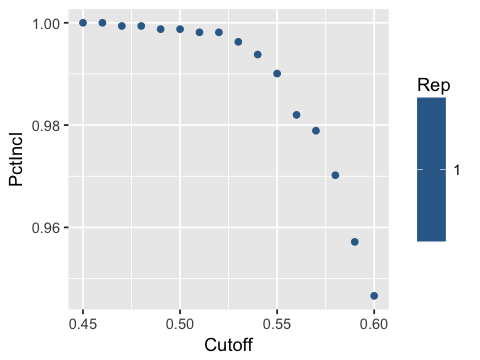

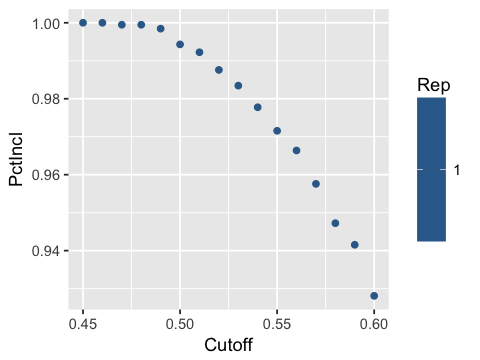

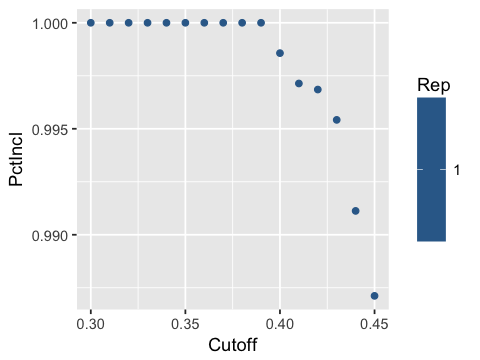

In [576]:
# Plot percent of OTUs included in largest cluster with increasing Spearman cutoffs
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.m.n)
p = p + geom_point(aes(x=Cutoff,y=PctIncl, color=Rep))
p

p = ggplot(df.o.n)
p = p + geom_point(aes(x=Cutoff,y=PctIncl, color=Rep))
p

p = ggplot(df.n)
p = p + geom_point(aes(x=Cutoff,y=PctIncl, color=Rep))
p

In [577]:
#### Matrix with just noise added ####

## To calculate minimum distance between taxa across the whole dataset
# Basically, it will be 1/[the most total sequences across all samples]
mindist = min(1/max(sample_sums(ps.f)),1/max(sample_sums(ps.m),1/max(sample_sums(ps.v))))
# Across all datasets, the minimum distance between taxa within a sample
delta = mindist*10^-2
# Just to be generous

# Setting up the data frame
Rep=c()
cutoff=c()
PercentIncl=c()
df.list=data.frame(Rep,cutoff,PercentIncl)

noise_function = function(ps){
    # Running it multiple times
    for (i in 1:10){

    # Record iteration
    Rep = i

    # Making matrix of random values that are less than smallest difference between two samples
    b = delta/1000
    E = replicate(dim(otu_table(ps))[1], rnorm(dim(otu_table(ps))[2]))
    E = 2*b*E
    E = -b + E

    otu_table(ps) = otu_table(as.matrix(otu_table(ps))+abs(t(E)),taxa_are_rows=FALSE)
    # Add the noise to the matrix

    ps.dist = cor(otu_table(ps), use="everything", method="spearman") 
    # Calculate spearman correlations

    # Apply the function to the range of values and turn it into a dataframe
    df = t(sapply(inputs,cutoff_function,ps=ps.dist))
    df = data.frame(df)
    df = data.frame(i,df)
    colnames(df) = colnames(df.list)
    df.list=rbind(df.list,df)
    }
colnames(df.list) = c("Rep","Cutoff","PctIncl")
return(df.list)
}

df.m.e = noise_function(ps.mini.m)
df.o.e = noise_function(ps.mini.o)
df.e = noise_function(ps.mini)

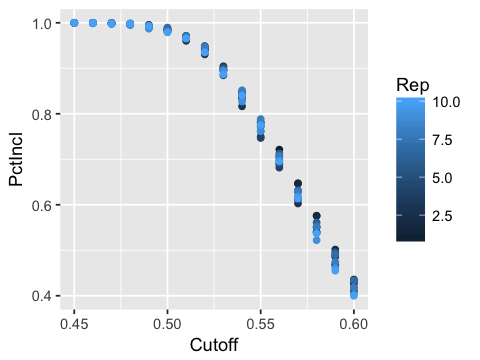

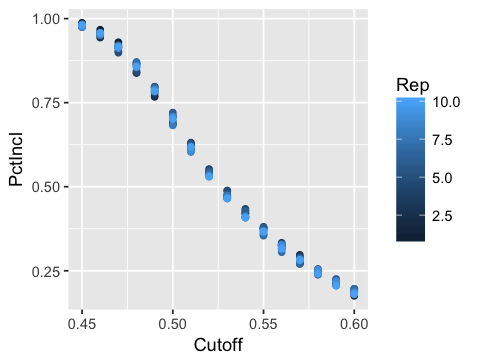

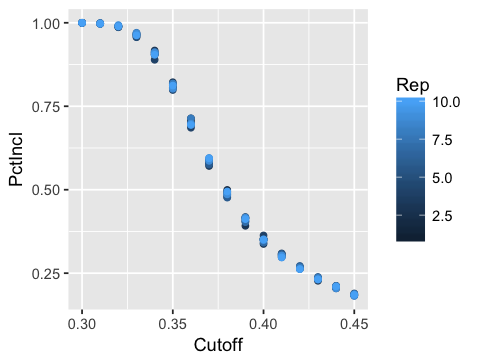

In [578]:
# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.m.e,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p

p = ggplot(df.o.e,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p

p = ggplot(df.e,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p
# As we can see, including random error to break ties
# Reduces the number of taxa included in the network.

In [579]:
#### Matrix with noise and permuations added ####

# Setting up the data frame
Rep=c()
Cutoff=c()
PctIncl=c()
df.list.permute=data.frame(Rep,Cutoff,PctIncl)


permute_noise_function = function(ps){
    # Running it multiple times
    for (i in 1:30){

        # Record iteration
        Rep = i
        
        # Making matrix of random values as above
        b = delta/1000
        E = replicate(dim(otu_table(ps))[1], rnorm(dim(otu_table(ps))[2]))
        E = 2*b*E
        E = -b + E

        otu_table(ps) = otu_table(as.matrix(otu_table(ps))+abs(t(E)),taxa_are_rows=FALSE)
        # Add the noise to the matrix

        M = matrix(otu_table(ps))
        # Get the OTU table as matrix

        n = dim(M)[1]*dim(M)[2]
        # number of elements in matrix

        M.new = matrix(base::sample(M, n, replace=TRUE),nrow=dim(otu_table(ps))[1])
        # Sample the matrix with replacement; make new random matrix

        ps.dist = cor(M.new, use="everything", method="spearman") 
        # Calculate spearman correlations

        # Apply the function to the range of values and turn it into a dataframe
        df = t(sapply(inputs, cutoff_function, ps=ps.dist))
        df = data.frame(df)
        df = data.frame(i,df)
        colnames(df) = colnames(df.list.permute)
        df.list.permute=rbind(df.list.permute,df)
    }
colnames(df.list.permute) = c("Rep","Cutoff","PctIncl")
return(df.list.permute)
}

df.m.p = permute_noise_function(ps.mini.m)
df.o.p = permute_noise_function(ps.mini.o)
df.p = permute_noise_function(ps.mini)

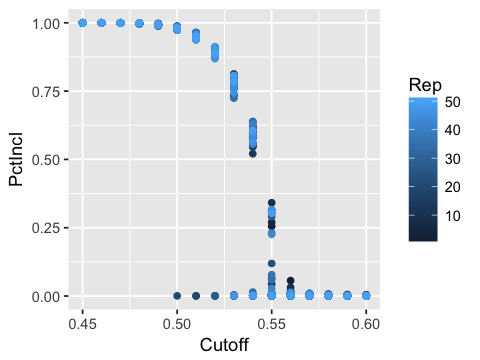

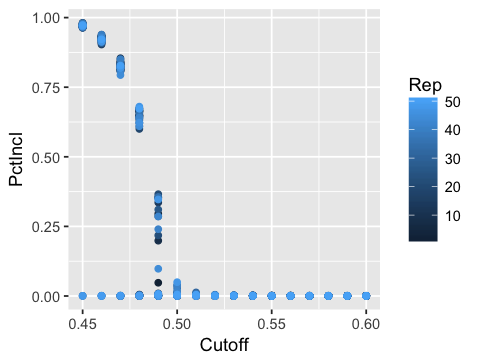

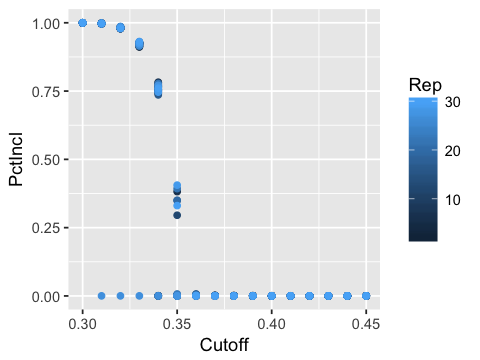

In [580]:
# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.m.p,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p

p = ggplot(df.o.p,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p

p = ggplot(df.p,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p
# As we can see, permuting the matrix randomly still makes networks.
# We must choose a rho cutoff that is above the random threshold.

In [581]:
# Joining the three types of runs together
df.m.n$Set = "Nothing"
df.m.p$Set = "Error+Permute"
df.m.e$Set = "Error"
df.full.m = rbind(df.m.n,df.m.e,df.m.p)

df.o.n$Set = "Nothing"
df.o.p$Set = "Error+Permute"
df.o.e$Set = "Error"
df.full.o = rbind(df.o.n,df.o.e,df.o.p)

df.n$Set = "Nothing"
df.p$Set = "Error+Permute"
df.e$Set = "Error"
df.full = rbind(df.n,df.e,df.p)

In [595]:
max(df.full.o[df.full.o$Cutoff==0.52 & df.full.o$Set=="Error+Permute",]$PctIncl)
max(df.full.m[df.full.m$Cutoff>=0.58 & df.full.m$Cutoff<0.59 & df.full.m$Set=="Error+Permute",]$PctIncl)
max(df.full[df.full$Cutoff==0.37  & df.full$Set=="Error+Permute",]$PctIncl)
# Choosing a value that keeps the max below 0.01 (1%)

[1] 0.004655975

[1] 0.006828057

[1] 0.002576582

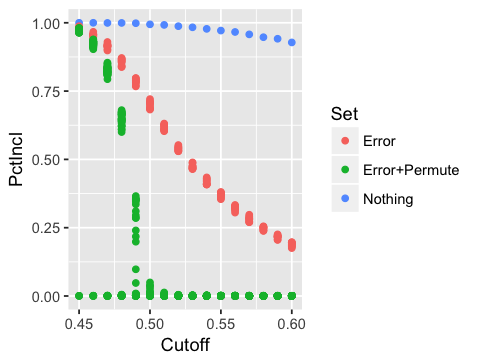

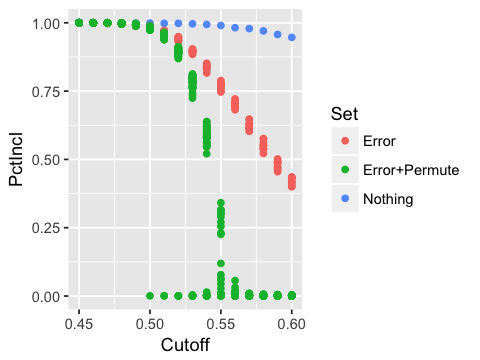

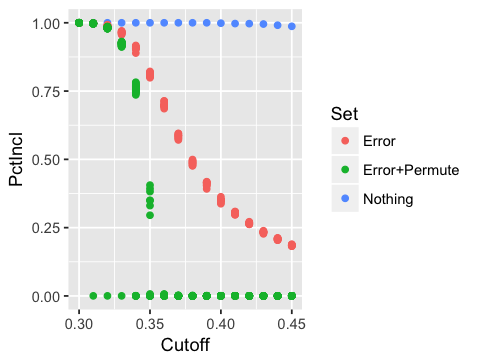

In [582]:
# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.full.o,aes(x=Cutoff,y=PctIncl, color=Set)) + geom_point() #+ ylim(c(0,0.1))
p

p = ggplot(df.full.m,aes(x=Cutoff,y=PctIncl, color=Set)) + geom_point() #+ ylim(c(0,0.1))
p

p = ggplot(df.full,aes(x=Cutoff,y=PctIncl, color=Set)) + geom_point() #+ ylim(c(0,0.1))
p

### The above code basically does what we want - calculates how large the largest cluster is for each of the rho cutoff values, with no alterations, adding random error, and adding random error plus rearranging the matrix randomly to result in no expected correlations. Thus, we can see where the rho cutoff values fall for all options. We should choose a cutoff that is higher than where the permuted one reaches ~1% of the OTUs being included in the largest cluster. We can then look at that cutoff in the actual (with added random error) data.  
#### For the M horizon dataset, that value is around 0.55 (choose 0.58). For O, around 0.5 (choose 0.52). For full, around 0.35 (choose 0.37). To be really confident in this, any chosen cutoff should be examined to make sure small variations in its value do not affect ecological conclusions  

####  "In practice, we suggest choosing a threshold slightly above the noise transition produced by the permutation test, and well below the point where the network breaks up into small, disconnected components."; "The threshold should be large enough to be above the noise transition (green line), but small enough that the network is not mostly disconnected."

Now we should be ready to use that cutoff to calculate the various parameters of the system.

###  Now, to test our confidence in the overall network developed, we will caculate a series of parameters about the network, and determine their null distributions.

#### First, we will use the derived network, based on the cutoff that we chose above.

In [597]:
#### Matrix with just noise added ####

# Chosen based on above calculations
rho.m = 0.58
rho.o = 0.52
rho.om = 0.37

matrix_parameters = function(ps,rho){
df.reps=data.frame(m=c(),n=c(),k=c(),apl=c(),c=c())
    #Starting out running it 100 times
    for (i in 1:100){

        # Record iteration
        Rep = i

        # Making matrix of random values
        b = delta/1000
        E = replicate(dim(otu_table(ps))[1], rnorm(dim(otu_table(ps))[2]))
        E = 2*b*E
        E = -b + E

        otu_table(ps) = otu_table(as.matrix(otu_table(ps))+abs(t(E)),taxa_are_rows=FALSE)
        # Add the noise to the matrix

    ps.dist = cor(otu_table(ps), use="everything", method="spearman") 
    # Calculate spearman correlations

    adjacency_matrix = as.matrix(ps.dist)
    # Turns Spearman into matrix
    
        adjacency_matrix[abs(adjacency_matrix)<rho] = 0
        adjacency_matrix[abs(adjacency_matrix)>rho] = 1
        adjacency_matrix = adjacency_matrix[rowSums(adjacency_matrix)>0,]
        # Set correlations below rho cutoff to 0, and above to 1
        # Remove all taxa that have no correlations above the cutoff.
    
        adjacency_matrix = graph.adjacency(adjacency_matrix, diag=FALSE, mode=c("undirected"), weighted=TRUE)
        # Create adjacency matrix from correlation matrix

        edge_list = get.edgelist(adjacency_matrix)
        # Gets edge list from adjacency matrix
    
        N = graph_from_data_frame(edge_list,directed=FALSE)
        # Creates the network
    
        m = ecount(N)
        # Number of edges
        n = vcount(N)
        # Number of nodes
        k = 2*m/n
        # Average degree
        apl = mean_distance(N,directed=FALSE)
        # Average path length
        c = transitivity(N)
        # Clustering coefficient of whole graph
    
        # Apply the function to the range of values and turn it into a dataframe
        df = data.frame(m,n,k,apl,c)
        colnames(df) = colnames(df.reps)
        df.reps=rbind(df.reps,df)
    }
colnames(df.reps)=c("m","n","k","apl","c")
return(df.reps)
}
df.m.reps = matrix_parameters(ps.mini.m,rho.m)
df.o.reps = matrix_parameters(ps.mini.o,rho.o)
df.reps = matrix_parameters(ps.mini,rho.om)

In [598]:
k.ave.o = mean(df.o.reps$k)
n.ave.o = mean(df.o.reps$n)
edges.o = k.ave.o * n.ave.o / 2
p.o = edges.o * 2 / (n.ave.o*n.ave.o)

k.ave.m = mean(df.m.reps$k)
n.ave.m = mean(df.m.reps$n)
edges.m = k.ave.m * n.ave.m / 2
p.m = edges.m * 2 / (n.ave.m*n.ave.m)

k.ave = mean(df.reps$k)
n.ave = mean(df.reps$n)
edges = k.ave * n.ave / 2
p = edges * 2 / (n.ave*n.ave)
# Probability that any pair of verticies is connected
# Thus we can generate a random matrix that preserved the degree of the network

In [599]:
ER_function = function(k.ave,n.ave,edges,p){
    df.ER=data.frame(Rep=c(),m=c(),n=c(),k=c(),apl=c(),c=c())

    for (i in 1:100){
    Rep=i
    ER.thresh = matrix(runif(round(n.ave)*round(n.ave)),ncol=round(n.ave))
    # Makes a random uniform matrix with the average number of nodes
    ER.thresh[upper.tri(ER.thresh,diag=FALSE) & ER.thresh < (1-p)] = 0
    ER.thresh[upper.tri(ER.thresh,diag=FALSE) & ER.thresh > (1-p)] = 1
    # Set anything in the upper triangle that is below the threshold (1-p) to zero and anything above to 1
    ER.thresh[lower.tri(ER.thresh,diag=FALSE)] = 0
    # Reflect the upper triangle to the lower triangle
    diag(ER.thresh) = 0
    # Set the diagonal to 0 (no self-connections)
    # This is the ER random thresholded matrix

    adjacency_matrix = graph.adjacency(ER.thresh, diag=FALSE, mode=c("undirected"), weighted=TRUE)
    # Create adjacency matrix from correlation matrix

    edge_list = get.edgelist(adjacency_matrix)
    # Gets edge list from adjacency matrix
    
    N = graph_from_data_frame(edge_list,directed=FALSE)
    # Creates the network
    
    m = ecount(N)
    # Number of edges
    n = vcount(N)
    # Number of nodes
    k = 2*m/n
    # Average degree
    apl = mean_distance(N,directed=FALSE)
    # Average path length
    c = transitivity(N)
    # Clustering coefficient of whole graph
    
    # Apply the function to the range of values and turn it into a dataframe
    df = data.frame(Rep,m,n,k,apl,c)
    colnames(df) = colnames(df.ER)
    df.ER=rbind(df.ER,df)
}
colnames(df.ER)=c("Rep","m","n","k","apl","c")
return(df.ER)
}

ER.o = ER_function(k.ave.o,n.ave.o,edges.o,p.o)
ER.m = ER_function(k.ave.m,n.ave.m,edges.m,p.m)
ER = ER_function(k.ave,n.ave,edges,p)

In [600]:
head(ER.o)
head(df.o.reps)

head(ER.m)
head(df.m.reps)

head(ER)
head(df.reps)

Rep,m,n,k,apl,c
1,4121,1252,6.583067,3.995943,0.006356164
2,3990,1253,6.368715,4.054142,0.006124807
3,4118,1254,6.567783,4.001900,0.005764541
4,4022,1253,6.419792,4.049740,0.003878247
5,4134,1254,6.593301,4.002835,0.005788282
6,3994,1253,6.375100,4.059417,0.004239284


m,n,k,apl,c
3816,1264,6.037975,4.610123,0.2878659
3877,1255,6.178486,4.657065,0.2826740
3898,1255,6.211952,4.526863,0.2852480
4047,1266,6.393365,4.611718,0.2868926
3887,1245,6.244177,4.645316,0.2871249
3908,1236,6.323625,4.401454,0.2895832


Rep,m,n,k,apl,c
1,3217,1062,6.058380,4.069316,0.004775843
2,3202,1063,6.024459,4.089139,0.006240899
3,3202,1066,6.007505,4.091885,0.006709315
4,3242,1066,6.082552,4.073255,0.005085529
5,3185,1064,5.986842,4.100360,0.005964215
6,3176,1065,5.964319,4.106239,0.005826466


m,n,k,apl,c
3053,1028,5.939689,4.795399,0.2785387
3174,1112,5.708633,5.061578,0.2848625
3190,1094,5.831810,4.909977,0.2833779
3185,1065,5.981221,4.841407,0.2808843
3136,1068,5.872659,4.848560,0.2817702
3175,1084,5.857934,4.875235,0.2788771


Rep,m,n,k,apl,c
1,11844,2360,10.037288,3.625220,0.003877639
2,11697,2360,9.912712,3.641762,0.004763836
3,11711,2359,9.928783,3.639705,0.004115084
4,11666,2359,9.890632,3.643682,0.004077287
5,11748,2360,9.955932,3.636491,0.004028163
6,11708,2360,9.922034,3.638255,0.004266726


m,n,k,apl,c
11429,2283,10.012265,4.240165,0.2763600
11673,2345,9.955650,4.231291,0.2771549
11485,2372,9.683811,4.377374,0.2789593
11420,2356,9.694397,4.307957,0.2737440
11648,2382,9.780017,4.263101,0.2775406
11685,2369,9.864922,4.244659,0.2791418


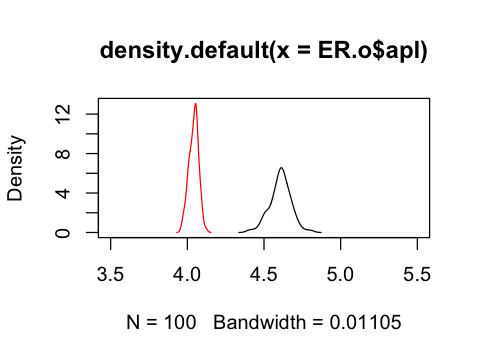

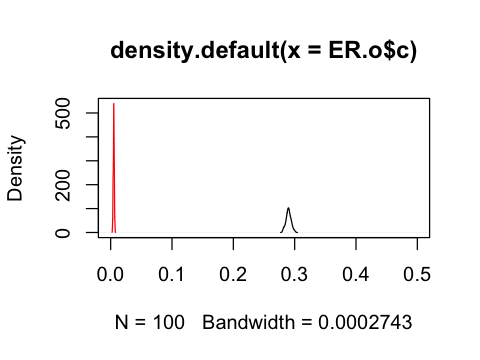

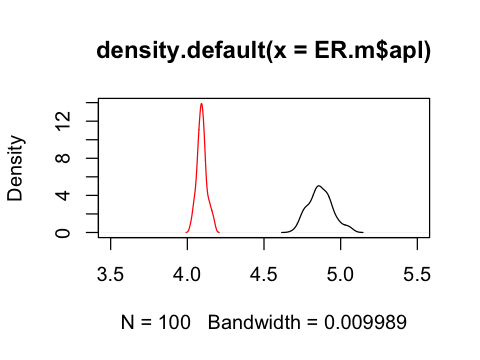

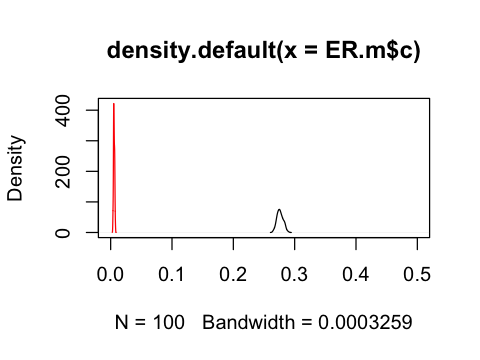

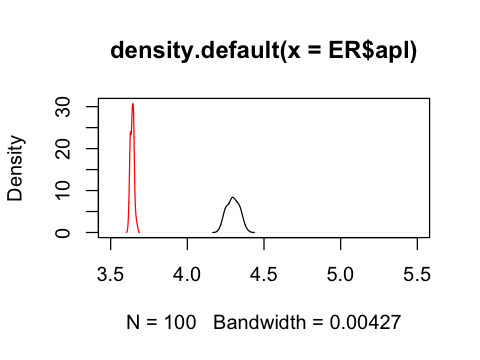

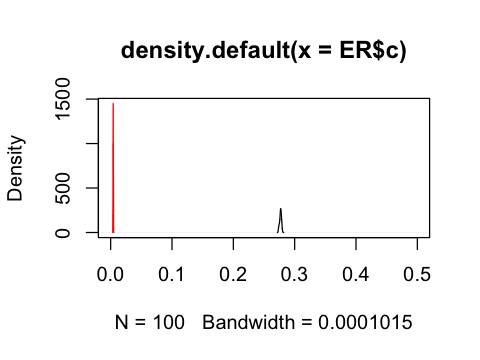

In [601]:
plot(density(ER.o$apl),xlim=c(3.5,5.5),col="red")
lines(density(df.o.reps$apl))

plot(density(ER.o$c),xlim=c(0,0.5),col="red")
lines(density(df.o.reps$c))

plot(density(ER.m$apl),xlim=c(3.5,5.5),col="red")
lines(density(df.m.reps$apl))

plot(density(ER.m$c),xlim=c(0,0.5),col="red")
lines(density(df.m.reps$c))

plot(density(ER$apl),xlim=c(3.5,5.5),col="red")
lines(density(df.reps$apl))

plot(density(ER$c),xlim=c(0,0.5),col="red")
lines(density(df.reps$c))

# The red traces represent the distribuiton of values for a random network with similar properties
# Since our true values lie outside of these, generally, this is good - if the network is randomly all connected,
# Average path length would be low - everything is connected. More structure increases APL.

### Since our network statistics seem to lie well outside of the null distributions (more clustering and longer path length), it seems like there is a good chance that our network is not just representing random noise. The clustering coefficients are ~0.28;  the Connor paper  was 0.38.

### Now we are ready to determine a consensus network. Connor et al. ran 2000 network simulations with added noise and using their permutationally-verified rho cutoff, and included edges that were present in 90% of their simulations. We will do 2000 at 95%, just to be a bit more sure.

In [904]:
#### Running consensus network ####

consensus_network = function(ps,rho){
    EL = data.frame(Rep=c(),X1=c(),X2=c())

    # Running it 2000 times
    for (i in 1:2000){

    # Record iteration
    Rep = i
    
    # Making matrix of random values
    b = delta/1000
    E = replicate(dim(otu_table(ps))[1], rnorm(dim(otu_table(ps))[2]))
    E = 2*b*E
    E = -b + E

    otu_table(ps) = otu_table(as.matrix(otu_table(ps))+abs(t(E)),taxa_are_rows=FALSE)
    # Add the noise to the matrix

    ps.dist = cor(otu_table(ps), use="everything", method="spearman") 
    # Calculate spearman correlations

    adjacency_matrix = as.matrix(ps.dist)
    # Turns Spearman into matrix
    
    adjacency_matrix[abs(adjacency_matrix)<rho] = 0
    adjacency_matrix[abs(adjacency_matrix)>rho] = 1
    adjacency_matrix = adjacency_matrix[rowSums(adjacency_matrix)>0,]
    # Set correlations below rho cutoff to 0, and above to 1
    # Remove all taxa that have no correlations above the cutoff.
    
    adjacency_matrix = graph.adjacency(adjacency_matrix, diag=FALSE, mode=c("undirected"), weighted=TRUE)
    # Create adjacency matrix from correlation matrix

    edge_list = get.edgelist(adjacency_matrix)
    # Gets edge list from adjacency matrix
    
    edge_list = data.frame(Rep,edge_list)

    EL = rbind(EL,edge_list)

    }
EL$X3=""
EL$X3 = apply(EL,1,function(x) paste(sort(c(paste(x[2]),paste(x[3])))[1],sort(c(paste(x[2]),paste(x[3])))[2]))
# The issue is that the pairing "Bsq2 Bsq5" can also be written "Bsq5 Bsq2"
# If we want to match the pairings, we need to make sure they are always written the same way
# To do this, we take X1 and X2 (the two nodes) and put them in a consistent order (~alphabetical)
# (The above code is quite a bit (1-2x) faster than a paralellized mapply or a for loop to do this.)
return(EL)
}

EL.o = consensus_network(ps.mini.o,rho.o)
saveRDS(EL.o,"EL.o.x-x-x")
EL.m = consensus_network(ps.mini.m,rho.m)
saveRDS(EL.m,"EL.m.x-x-x")
EL.om = consensus_network(ps.mini,rho.om)
saveRDS(EL.om,"EL.om.x-x-x")

In [2]:
EL.o=readRDS("EL.o.9-12-2018")
EL.m=readRDS("EL.m.9-12-2018")
EL.om=readRDS("EL.om.9-12-2018")

In [3]:
# Finds how many instances of each pairing there are
Common.o = EL.o %>%
    group_by(X3)%>%
    summarize(n())
Common.m = EL.m %>%
    group_by(X3)%>%
    summarize(n())
Common.om = EL.om %>%
    group_by(X3)%>%
    summarize(n())

# We want those that are present 95% of the time
# For 2000 runs, that's n>=1900 or higher.
Consensus.o = Common.o[Common.o[,2]>=1900,]
Consensus.m = Common.m[Common.m[,2]>=1900,]
Consensus.om = Common.om[Common.om[,2]>=1900,]

dim(EL.o)
dim(Common.o)
dim(Consensus.o)

dim(EL.m)
dim(Common.m)
dim(Consensus.m)

dim(EL.om)
dim(Common.om)
dim(Consensus.om)

[1] 8099586       4

[1] 55889     2

[1] 963   2

[1] 6102465       4

[1] 41200     2

[1] 676   2

[1] 22666545        4

[1] 124632      2

[1] 3454    2

In [4]:
# Divide the 95%-present paired responders back into two columns
# This is our consensus edge list
edge_list_consensus.o = separate(Consensus.o,1,into=c("X1","X2"),sep=" ")
edge_list_consensus.o = edge_list_consensus.o[,1:2]
edge_list_consensus.m = separate(Consensus.m,1,into=c("X1","X2"),sep=" ")
edge_list_consensus.m = edge_list_consensus.m[,1:2]
edge_list_consensus.om = separate(Consensus.om,1,into=c("X1","X2"),sep=" ")
edge_list_consensus.om = edge_list_consensus.om[,1:2]

In [5]:
edge_list.o = edge_list_consensus.o
edge_list.m = edge_list_consensus.m
edge_list.om = edge_list_consensus.om
# Setting edge list to the consensus value
# Then running through all previous graphing code

colnames(edge_list.o)=c("A","B")
edge_list.o=data.frame(edge_list.o)
edge_list.o$CorVal=""
edge_list.o$CorSign=""

colnames(edge_list.m)=c("A","B")
edge_list.m=data.frame(edge_list.m)
edge_list.m$CorVal=""
edge_list.m$CorSign=""

colnames(edge_list.om)=c("A","B")
edge_list.om=data.frame(edge_list.om)
edge_list.om$CorVal=""
edge_list.om$CorSign=""

In [6]:
# Want to add correlation values and colors for the consensus edges
# Because there are many edges, this takes a while.

Cor_sign_estimate = function(ps,edge_list){
    ps.dist = cor(otu_table(ps), use="everything", method="spearman") 
    for (i in 1:dim(edge_list)[1]){
        CorVal = ps.dist[which(rownames(ps.dist)==data.frame(edge_list)$A[i]),
                 which(colnames(ps.dist)==data.frame(edge_list)$B[i])]
        CorSign = ifelse(CorVal>0,"Positive","Negative")
        edge_list[i,3]=CorVal
        edge_list[i,4]=CorSign
    }
edge_list$EdgeColor[edge_list$CorSign=="Positive"] = "black"
edge_list$EdgeColor[edge_list$CorSign=="Negative"] = "red"

return(edge_list)
}

edge_list.o = Cor_sign_estimate(ps.mini.o,edge_list.o)
edge_list.m = Cor_sign_estimate(ps.mini.m,edge_list.m)
edge_list.om = Cor_sign_estimate(ps.mini,edge_list.om)

# Correlation values are relying on the last ps.dist.mini run
# Which could be different for each run, but we can assume,
# If it's consensus, and using the right cutoff,
# we should not be getting changing signs of correlation from one run to the next

ERROR: Error in otu_table(ps): object 'ps.mini.o' not found


In [ ]:
igraph.o = graph_from_data_frame(edge_list.o,directed=FALSE)
igraph.m = graph_from_data_frame(edge_list.m,directed=FALSE)
igraph.om = graph_from_data_frame(edge_list.om,directed=FALSE)

In [ ]:
# Get the taxon info for nodes
node_list.o = data.frame(V(igraph.o)$name)
node_list.m = data.frame(V(igraph.m)$name)
node_list.om = data.frame(V(igraph.om)$name)

# Add the OTU ID column
colnames(node_list.o)[1] = "OTU"
colnames(node_list.m)[1] = "OTU"
colnames(node_list.om)[1] = "OTU"

In [ ]:
# Add fire-responsive data to the node list
l2FC.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fc.df")
l2FC.f =readRDS("CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")

m = l2FC.m%>%
    group_by(logFC,sigBurn,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(AveExpr))%>%
    group_by(logFC,MeanAbund,sigBurn,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigBurn==1)%>%
    filter(logFC>0)%>%
    arrange(OTU)
m$OTU = gsub("sq","Bsq",m$OTU)
m.fire.pos = levels(as.factor(m$OTU))

m = l2FC.m%>%
    group_by(logFC,sigBurn,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(AveExpr))%>%
    group_by(logFC,MeanAbund,sigBurn,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigBurn==1)%>%
    filter(logFC<0)%>%
    arrange(OTU)
m$OTU = gsub("sq","Bsq",m$OTU)
m.fire.neg = levels(as.factor(m$OTU))

f = l2FC.f%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(AveExpr))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC>0)%>%
    arrange(OTU)
f$OTU = gsub("sq","Fsq",f$OTU)
f.fire.pos = levels(as.factor(f$OTU))

f = l2FC.f%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(AveExpr))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC<0)%>%
    arrange(OTU)
f$OTU = gsub("sq","Fsq",f$OTU)
f.fire.neg = levels(as.factor(f$OTU))

# Assigning fire response variables from l2FC calculation results
Assign_fireresp = function(node_list){
    node_list$FireResponseColor = ""
    for (i in 1:dim(node_list)[1]){
        OTU = node_list$OTU[i]
        FireResponseColor = ifelse((OTU %in% f.fire.pos | OTU %in% m.fire.pos),"red",
                               ifelse((OTU %in% f.fire.neg | OTU %in% m.fire.neg),"lightskyblue3","white"))
        node_list$FireResponseColor[i] = FireResponseColor
    }
return(node_list)
}

node_list.o = Assign_fireresp(node_list.o)
node_list.m = Assign_fireresp(node_list.m)
node_list.om = Assign_fireresp(node_list.om)

In [ ]:
# Ensuring we have the fungal guilds data
F.guilds = tax_table(ps.f.norm)
row.names(F.guilds) = gsub("sq","Fsq",row.names(F.guilds))
F.guilds = F.guilds[,c("Trophic.Mode","Guild","Growth.Morphology")]

In [ ]:
# Adding taxonomy to the nodes list
taxonomy_labeller = function(ps,node_list){
node_list$Species = c()
node_list$Genus = c()
node_list$Family = c()
node_list$Order = c()
node_list$Class = c()
node_list$Phylum = c()
node_list$Kingdom = c()
node_list$Guild = c()
node_list$Trophic.Mode = c()
node_list$Growth.Morphology=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    Species = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Species"]),"")
    Genus = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Genus"]),"")
    Family = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Family"]),"")
    Order = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Order"]),"")
    Class = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Class"]),"")
    Phylum = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Phylum"]),"")
    Kingdom = ifelse(OTU %in% row.names(tax_table(ps)),paste(tax_table(ps)[paste(OTU),"Kingdom"]),"")
    Guild = ifelse(OTU %in% row.names(tax_table(F.guilds)),paste(tax_table(F.guilds)[paste(OTU),"Guild"]),"")
    Trophic.Mode = ifelse(OTU %in% row.names(tax_table(F.guilds)),paste(tax_table(F.guilds)[paste(OTU),"Trophic.Mode"]),"")
    GuildGrowth.Morphology= ifelse(OTU %in% row.names(tax_table(F.guilds)),paste(tax_table(F.guilds)[paste(OTU),"Growth.Morphology"]),"")
    node_list$Species[i] = Species
    node_list$Genus[i] = Genus
    node_list$Family[i] = Family
    node_list$Order[i] = Order
    node_list$Class[i] = Class
    node_list$Phylum[i] = Phylum
    node_list$Kingdom[i] = Kingdom
    node_list$Guild[i] = Guild
    node_list$Trophic.Mode[i] = Trophic.Mode
    node_list$Growth.Morphology[i] = GuildGrowth.Morphology
    node_list$SpecialName = paste("My name is",node_list$OTU)
}
return(node_list)
}
node_list.o = taxonomy_labeller(ps.mini.o,node_list.o)
node_list.m = taxonomy_labeller(ps.mini.m,node_list.m)
node_list.om = taxonomy_labeller(ps.mini,node_list.om)

In [ ]:
taxonomy_colourer = function(node_list){
node_list$Plants = ifelse(node_list$Kingdom=="Plantae","green",
                          ifelse(node_list$Kingdom=="Bacteria","navy",
                                 ifelse(node_list$Kingdom=="Archaea","red",
                                     ifelse(node_list$Kingdom=="Fungi","yellow",
                                            ifelse(node_list$Kingdom=="","yellow","white")))))
node_list$Penn = ifelse(node_list$OTU=="Bsq134","navy","grey")
node_list$Mort = ifelse(node_list$Genus=="Mortierella","navy","grey")
node_list$Phy = ifelse(node_list$Phylum=="Actinobacteria","orange",
                       ifelse(node_list$Phylum=="Gemmatimonadetes","blue",
                              ifelse(node_list$Phylum=="Acidobacteria","darkred",
                                     ifelse(node_list$Phylum=="Proteobacteria","darkgreen",
                                            ifelse(node_list$Phylum=="Bacteroidetes","black",
                                                   ifelse(node_list$Phylum=="Planctomycetes","pink",
                                                          ifelse(node_list$Phylum=="Firmicutes","red","white")))))))
node_list$Ord = ifelse(node_list$Order=="Eurotiales","navy","white")
node_list$Gen = ifelse(node_list$Genus=="Bradyrhizobium","navy","white")
node_list$Troph = ifelse(node_list$Trophic.Mode=="Saprotroph","navy","white")
node_list$GM = ifelse(node_list$Growth.Morphology=="Yeast","navy",
                      ifelse(node_list$Growth.Morphology=="Microfungus","blue",
                             ifelse(node_list$Growth.Morphology=="Agaricoid","red",
                                    ifelse(node_list$Growth.Morphology=="Boletoid","darkgreen","white"))))
return(node_list)
}
node_list.o = taxonomy_colourer(node_list.o)
node_list.m = taxonomy_colourer(node_list.m)
node_list.om = taxonomy_colourer(node_list.om)

In [ ]:
### Adding Global Soil Atlas Info
# Read in the BLAST results from our OTUs vs. the Soil Atlas paper OTUs

blast = read.csv("../16S/GlobalAtlasBlast.txt",sep="\t",header=FALSE)
colnames(blast) = c("qseqid", "SoilAtlasID", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart" ,"send" ,"evalue","bitscore")

blast.filt = blast %>%
    filter(pident>=97)

blast.filt$OTU=matrix(unlist(strsplit(paste(blast.filt$qseqid),split=";",fixed=TRUE)),ncol=2,byrow=TRUE)[,1]
SoilAtlas = read.csv("../16S/GlobalAtlasMetaData.csv",header=TRUE)
colnames(SoilAtlas)=c("SoilAtlasID","SAPhylum","SAClass","SAOrder","SAFamily","SAGenus","SASpecies","SA_RF_best_pred","SA_Ecol_cluster")
blast.filt = merge(blast.filt,SoilAtlas,by="SoilAtlasID",all.x=TRUE)

blast.filt = blast.filt%>%
    dplyr::group_by(OTU)%>%
    dplyr::filter(pident==max(pident))%>%
    dplyr::summarize(pident=mean(pident),SoilAtlasID=paste(SoilAtlasID,collapse=";"),SA_Ecol_cluster=paste(droplevels((as.factor(SA_Ecol_cluster))),collapse=";"))%>%
    dplyr::arrange(OTU)
blast.filt$OTU=paste("B",blast.filt$OTU,sep="")

## Adding Global Soil Atlas data to node list
add_GSA = function(node_list){
    node_list = merge(node_list,blast.filt,by="OTU",all.x=TRUE)
    
    node_list$SoilAtlasColor = ifelse(!is.na(node_list$SoilAtlasID),"grey40",
                                  ifelse(node_list$Kingdom != "Bacteria", "white", "grey75"))

    palette = (brewer.pal(9, "YlGnBu")[3:9])[c(3,2,1)]
    node_list$SoilAtlasColorECO = ifelse(is.na(node_list$SA_Ecol_cluster),"white",
                                    ifelse(node_list$SA_Ecol_cluster=="High pH",palette[1],
                                      ifelse(node_list$SA_Ecol_cluster=="Low pH",palette[3],
                                         ifelse(node_list$SA_Ecol_cluster=="Drylands","red",
                                            ifelse(node_list$SA_Ecol_cluster=="Dry-forests","black","white")))))
return(node_list)
}
#node_list.o = add_GSA(node_list.o)
#node_list.m = add_GSA(node_list.m)
#node_list.om = add_GSA(node_list.om)

In [ ]:
# Calculate standard properties of networks
   
network_properties = function(edge_list){
    N = graph_from_data_frame(edge_list,directed=FALSE)
    # Creates the network
    
    m = ecount(N)
    # Number of edges
    n = vcount(N)
    # Number of nodes
    k = 2*m/n
    # Average degree
    apl = mean_distance(N,directed=FALSE)
    # Average path length
    c = transitivity(N, type="global")
    cAve = transitivity(N, type = "average")
    # Clustering coefficient of whole graph - 
    # Transitivity measures the probability that the adjacent vertices of a vertex are connected.
    cl.mean = mean(closeness(N))
    cl.sd = sd(closeness(N))
    # closeness of graph
    ed = edge_density(N)
    # edge density of graph
    d = diameter(N)
    # diameter of graph
    
    # Turn it into a dataframe
    df = data.frame(m,n,k,apl,c,cAve,cl.mean,cl.sd,ed,d)
    return(df)
}
net.prop.o = network_properties(edge_list.o)
net.prop.m = network_properties(edge_list.m)
net.prop.om = network_properties(edge_list.om)
net.prop.o
net.prop.m
net.prop.om

In [ ]:
# From https://chengjunwang.com/web_data_analysis/demo2_simulate_networks/
# plot and fit the power law distribution
fit_power_law = function(edge_list) {
    N = graph_from_data_frame(edge_list,directed=FALSE)
    # calculate degree
    d = degree(N, mode = "all")
    dd = degree.distribution(N, mode = "all", cumulative = FALSE)
    degree = 1:max(d)
    probability = dd[-1]
    # delete blank values
    nonzero.position = which(probability != 0)
    probability = probability[nonzero.position]
    degree = degree[nonzero.position]
    reg = lm(log(probability) ~ log(degree))
    cozf = coef(reg)
    power.law.fit = function(x) exp(cozf[[1]] + cozf[[2]] * log(x))
    alpha = -cozf[[2]]
    R.square = summary(reg)$r.squared
    print(paste("Alpha =", round(alpha, 3)))
    print(paste("R square =", round(R.square, 3)))
    # plot
    plot(probability ~ degree, log = "xy", xlab = "Degree (log)", ylab = "Probability (log)", 
        col = 1, main = "Degree Distribution")
    curve(power.law.fit, col = "red", add = T, n = length(d))
}

fit_power_law(edge_list.o)
fit_power_law(edge_list.m)
fit_power_law(edge_list.om)

In [ ]:
# We want to calculate other standard parameters for the network (from Shi et al. 2016):

In [ ]:
# Modules can be detected using the greedy modularity optimisation method (Deng et al. 2012) 
#Modules.o = cluster_fast_greedy(graph=igraph.o, merges = TRUE, modularity = TRUE, membership = TRUE)
#Modules.m = cluster_fast_greedy(graph=igraph.m, merges = TRUE, modularity = TRUE, membership = TRUE)
#Modules.om = cluster_fast_greedy(graph=igraph.om, merges = TRUE, modularity = TRUE, membership = TRUE)

In [30]:
# Modules can be detected using the cluster walktrap method - similar to greedy, somewhat smaller modules
# Pascal Pons, Matthieu Latapy: Computing communities in large networks using random walks
# http://arxiv.org/abs/physics/0512106

Modules.o = cluster_walktrap(graph=igraph.o, merges = TRUE, modularity = TRUE, membership = TRUE)
Modules.m = cluster_walktrap(graph=igraph.m, merges = TRUE, modularity = TRUE, membership = TRUE)
Modules.om = cluster_walktrap(graph=igraph.om, merges = TRUE, modularity = TRUE, membership = TRUE)

In [ ]:
# Modularity (M) is an index measuring the extent to which a network is divided into modules, 
# and we used M > 0.4 as the threshold to define modular structures (Newman 2006)
# All our networks have meaningful modularity.
modularity(Modules.o)
modularity(Modules.m)
modularity(Modules.om)

In [ ]:
# Connectivity of each node can be determined based on its within-module connectivity (Zi)
# and among-module connectivity (Pi) (Guimera & Amaral 2005)

# Zi and Pi can be used to classify the nodes based on the topological roles they play in the network
# Node topologies are organised into four categories: module hubs (highly connected nodes within modules, Zi > 2.5)
# network hubs (highly connected nodes within entire network, Zi > 2.5 and Pi > 0.62)
# connectors (nodes that connect modules, Pi > 0.62)
# and peripherals (nodes connected in modules with few outside connections, Zi < 2.5 and Pi < 0.62) (Olesen et al. 2007; Zhou et al. 2010; Deng et al. 2012).

# To calculate the Zi and Pi of each node:
# First, find out which module it is in
# Make a list of all the other nodes in that module
# Calculate the connectivity of that node to all those other nodes
# Do this for each node
# Then, Zi is calculated as:
# (number of links from a given node to other nodes in the module - the average number for nodes in this module)
# Divided by the standard deviation of this value for nodes in this module.

# Then, do the same, but make the nodes list all the nodes in other modules

In [ ]:
# First attempt at calculating Zi

adding_Zi = function(node_list,Modules,igraph){

    Zi=data.frame(Name=node_list$OTU,ModuleNumber=rep(0,length(node_list$OTU)),CON=rep(0,length(node_list$OTU)))
    # Establish empty dataframe

    for (i in 1:length(node_list$OTU)){
        node = paste(node_list$OTU[i])
        ModuleNumber = Position(function(x) node %in% x, Modules[], nomatch = 0)
        if(ModuleNumber !=0){
            ModuleNodes = Modules[[ModuleNumber]]
            modgraph = induced_subgraph(graph=igraph, v=c(ModuleNodes,node))
            CON=try(as.numeric(lengths(adjacent_vertices(modgraph,node))),TRUE)
            if(isTRUE(class(CON)=="try-error")) { CON=NA } else {CON = as.numeric(lengths(adjacent_vertices(modgraph,node)))}
        }
        if(ModuleNumber ==0){CON=NA}
    Zi$Name[i]=as.factor(node_list$OTU[i])
    Zi$ModuleNumber[i]=ModuleNumber
    Zi$CON[i]=CON
    }
                                
# (number of links from a given node to other nodes in the module - the average number for nodes in this module)
# Divided by the standard deviation of this value for nodes in this module.
    Zi = Zi %>%
        filter(!is.na(CON))%>%
        group_by(ModuleNumber)%>%
        mutate(MeanCON=mean(CON))%>%
        mutate(SdCON=sd(CON))%>%
        mutate(Zi=((CON-MeanCON)/SdCON))
return(Zi)
}
Zi.o = adding_Zi(node_list.o,Modules.o,igraph.o)
Zi.m = adding_Zi(node_list.m,Modules.m,igraph.m)
Zi.om = adding_Zi(node_list.om,Modules.om,igraph.om)

In [ ]:
# Next, we add Pi
adding_Pi = function(node_list,Modules,igraph){

    Pi=data.frame(Name=rep(node_list$OTU,dim(Modules[])),HomeModuleNumber=rep(0,length(node_list$OTU)),OtherModuleNumber=rep(0,length(node_list$OTU)),TotalCON=rep(0,length(node_list$OTU)),CON=rep(0,length(node_list$OTU)))
    # Establish empty dataframe

    for (i in 1:length(node_list$OTU)){
        node = paste(node_list$OTU[i])
        HomeModuleNumber = Position(function(x) node %in% x, Modules[], nomatch = 0)
        ModuleNumbers = 1:dim(Modules[])
        n = length(ModuleNumbers)
        TotalCON = as.numeric(lengths(adjacent_vertices(igraph,node)))
        lowend = (i-1)*n+1
        highend = n*i
        Pi$Name[lowend:highend]=node_list$OTU[i]
        Pi$HomeModuleNumber[lowend:highend]=HomeModuleNumber
        Pi$OtherModuleNumber[lowend:highend]=ModuleNumbers
        Pi$TotalCON[lowend:highend]=TotalCON
        if(HomeModuleNumber !=0){    
            for (j in ModuleNumbers){
                OtherModuleNumber = j
                NodesInOtherModule = Modules[[OtherModuleNumber]]
                modgraph = induced_subgraph(graph=igraph, v=c(node,NodesInOtherModule))
                CON=as.numeric(lengths(adjacent_vertices(modgraph,node)))
                Pi$CON[Pi$HomeModuleNumber==HomeModuleNumber & Pi$OtherModuleNumber==OtherModuleNumber & Pi$Name==node]=CON
            }
        }
    }
Pi$kk2 = (Pi$CON/Pi$TotalCON)^2
return(Pi)
}
Pi.o = adding_Pi(node_list.o,Modules.o,igraph.o)
Pi.m = adding_Pi(node_list.m,Modules.m,igraph.m)
Pi.om = adding_Pi(node_list.om,Modules.om,igraph.om)
                                    
Pifinal.o = Pi.o %>%
    group_by(Name,HomeModuleNumber,TotalCON)%>%
    summarize(Sum=sum(kk2))%>%
    mutate(Pi=1-Sum)

Pifinal.m = Pi.m %>%
    group_by(Name,HomeModuleNumber,TotalCON)%>%
    summarize(Sum=sum(kk2))%>%
    mutate(Pi=1-Sum)

Pifinal.om = Pi.om %>%
    group_by(Name,HomeModuleNumber,TotalCON)%>%
    summarize(Sum=sum(kk2))%>%
    mutate(Pi=1-Sum)

In [ ]:
# Calculating Zi from Pi data

Zinew.o = Pi.o %>% filter(HomeModuleNumber==OtherModuleNumber) %>% mutate(MeanCON=mean(CON),SdCON=sd(CON),Zi=((CON-MeanCON)/SdCON))
Zinew.m = Pi.m %>% filter(HomeModuleNumber==OtherModuleNumber) %>% mutate(MeanCON=mean(CON),SdCON=sd(CON),Zi=((CON-MeanCON)/SdCON))
Zinew.om = Pi.om %>% filter(HomeModuleNumber==OtherModuleNumber) %>% mutate(MeanCON=mean(CON),SdCON=sd(CON),Zi=((CON-MeanCON)/SdCON))

In [ ]:
# Bringing module data together

Making_module_data = function(Pifinal,Zinew){
    Pthresh = 0.62
    Zthresh = 2.5
    ModuleData=data.frame(Name=Pifinal$Name,Module=Pifinal$HomeModuleNumber,TotalCON=Pifinal$TotalCON,ModuleCON=Zinew$MeanCON,Pi=Pifinal$Pi,Zi=Zinew$Zi)
    ModuleData$Class = ifelse(ModuleData$Zi>Zthresh & ModuleData$Pi>Pthresh,"Network Hub",
                          ifelse(ModuleData$Zi>Zthresh & ModuleData$Pi<Pthresh,"Module Hub",
                            ifelse(ModuleData$Zi<Zthresh & ModuleData$Pi>Pthresh,"Connector", "Peripheral")))
return(ModuleData)
}

ModuleData.o = Making_module_data(Pifinal.o,Zinew.o)
ModuleData.m = Making_module_data(Pifinal.m,Zinew.m)
ModuleData.om = Making_module_data(Pifinal.om,Zinew.om)

In [ ]:
options(repr.plot.width=4, repr.plot.height=3)
# Of interest: https://www.quantamagazine.org/scant-evidence-of-power-laws-found-in-real-world-networks-20180215/
hist(ModuleData.om$TotalCON)

In [ ]:
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(ModuleData.o)
p = p + geom_point(aes(x=Pi,y=Zi,color=Class))
p

p = ggplot(ModuleData.m)
p = p + geom_point(aes(x=Pi,y=Zi,color=Class))
p

p = ggplot(ModuleData.om)
p = p + geom_point(aes(x=Pi,y=Zi,color=Class))
p

In [ ]:
## Add this info to the nodes list

add_modInfo = function(node_list,ModuleData){
    node_list$Pi=c()
    for (i in 1:dim(node_list)[1]){
        OTU = node_list$OTU[i]
        x = ifelse(OTU %in% ModuleData$Name, 
                ifelse(ModuleData[ModuleData$Name==OTU,]$Pi!=(-Inf),ModuleData[ModuleData$Name==OTU,]$Pi, NA))
        node_list$Pi[i] = x
    }

    node_list$Zi=c()
    for (i in 1:dim(node_list)[1]){
        OTU = node_list$OTU[i]
        x = ifelse(OTU %in% ModuleData$Name, 
                ifelse(ModuleData[ModuleData$Name==OTU,]$Zi!=(-Inf),ModuleData[ModuleData$Name==OTU,]$Zi, NA))
        node_list$Zi[i] = x
    }

    node_list$NetworkRole=c()
    for (i in 1:dim(node_list)[1]){
        OTU = node_list$OTU[i]
        x = ifelse(OTU %in% ModuleData$Name, 
                ifelse(ModuleData[ModuleData$Name==OTU,]$Class!=(-Inf),ModuleData[ModuleData$Name==OTU,]$Class, NA))
        node_list$NetworkRole[i] = x
    }

    node_list$Module=c()
    for (i in 1:dim(node_list)[1]){
        OTU = node_list$OTU[i]
        x = ifelse(OTU %in% ModuleData$Name, 
                ifelse(ModuleData[ModuleData$Name==OTU,]$Module!=(-Inf),ModuleData[ModuleData$Name==OTU,]$Module, NA))
        node_list$Module[i] = x
    }


    node_list$NetworkRoleColour = ifelse(node_list$NetworkRole=="Connector","red",
                                     ifelse(node_list$NetworkRole=="Module Hub","navy","white"))

return(node_list)
}

node_list.o = add_modInfo(node_list.o,ModuleData.o)
node_list.m = add_modInfo(node_list.m,ModuleData.m)
node_list.om = add_modInfo(node_list.om,ModuleData.om)

In [ ]:
colnames(node_list.om)

In [ ]:
ConnectorsNHubs.o = node_list.o[node_list.o$NetworkRole!="Peripheral",c(1,8,7,6,5,4,3,24,25)]%>%arrange(NetworkRole,Module)
write.csv(ConnectorsNHubs.o,"Connectors_and_hubs.o.csv")

In [86]:
# This should have given us all the edge, node, and module properties we want for each network.
# Save all:
#saveRDS(edge_list.o,"edge_list.o.9-12-2018")
#aveRDS(edge_list.m,"edge_list.m.9-12-2018")
#saveRDS(edge_list.om,"edge_list.om.9-12-2018")

#saveRDS(node_list.o,"node_list.o.9-12-2018")
#saveRDS(node_list.m,"node_list.m.9-12-2018")
#saveRDS(node_list.om,"node_list.om.9-12-2018")

#saveRDS(igraph.o,"igraph.o.9-12-2018")
#saveRDS(igraph.m,"igraph.m.9-12-2018")
#saveRDS(igraph.om,"igraph.om.9-12-2018")


### Start here to use most recent edge and node list

In [24]:
edge_list.o = readRDS("edge_list.o.9-12-2018")
edge_list.m = readRDS("edge_list.m.9-12-2018")
edge_list.om = readRDS("edge_list.om.9-12-2018")

node_list.o = readRDS("node_list.o.9-12-2018")
node_list.m = readRDS("node_list.m.9-12-2018")
node_list.om = readRDS("node_list.om.9-12-2018")

igraph.o = readRDS("igraph.o.9-12-2018")
igraph.m = readRDS("igraph.m.9-12-2018")
igraph.om = readRDS("igraph.om.9-12-2018")

In [25]:
# Check most abundant modules
ModProps.o = node_list.o %>% group_by(Module) %>% summarize(Total=n()) %>% arrange(-Total)
ModProps.m = node_list.m %>% group_by(Module) %>% summarize(Total=n()) %>% arrange(-Total)
ModProps.om = node_list.om %>% group_by(Module) %>% summarize(Total=n()) %>% arrange(-Total)

head(ModProps.o)
head(ModProps.m)
head(ModProps.om)

Module,Total
3,91
2,78
1,29
5,15
7,13
6,8


Module,Total
1,81
2,32
8,29
5,27
10,9
7,8


Module,Total
4,135
11,111
3,103
1,83
10,53
5,34


In [26]:
# Pull out all modules with more than (modcutoff) nodes

modcutoff = 4

AbundMods.o = ModProps.o %>% filter(Total>modcutoff) %>% select(Module)
AbundMods.m = ModProps.m %>% filter(Total>modcutoff) %>% select(Module)
AbundMods.om = ModProps.om %>% filter(Total>modcutoff) %>% select(Module)

AbundMods.o = AbundMods.o$Module
AbundMods.m = AbundMods.m$Module
AbundMods.om = AbundMods.om$Module

In [27]:
# Reporting properties of each module wrt bacteria (for modules with more than modcutoff taxa)

get_ModProps_bact = function(node_list, AbundMods){
ModProps = node_list %>%
    filter(Kingdom=="Bacteria")%>%
    filter(Module %in% AbundMods)%>%
    group_by(Module,Kingdom,Phylum)%>%
    summarize(Sum = n())%>%
    group_by(Module,Kingdom)%>%
    mutate(Fract = Sum/sum(Sum))%>%
    mutate(Tot = sum(Sum))%>%
    arrange(Module,-Fract)%>%
    mutate(Phylum=ifelse(Phylum=="Bacteria_unclassified(0)","Unclassified",Phylum))
ModProps$Module = as.factor(ModProps$Module)
ModProps$Module = droplevels((ModProps$Module))

ModProps$Phylum = as.factor(ModProps$Phylum)
ModProps$Phylum = droplevels((ModProps$Phylum))
PhyOrder = ModProps%>%
    group_by(Phylum)%>%
    summarize(Total=sum(Tot))%>%
    arrange(-Total)
PhyOrder = PhyOrder$Phylum
ModProps$Phylum = as.factor(ModProps$Phylum)
ModProps$Phylum = factor(ModProps$Phylum,levels=PhyOrder)
    
return(ModProps)
}

ModProps.bact.o = get_ModProps_bact(node_list.o,AbundMods.o)
ModProps.bact.m = get_ModProps_bact(node_list.m,AbundMods.m)
ModProps.bact.om = get_ModProps_bact(node_list.om,AbundMods.om)

In [28]:
# Reporting properties of each module wrt fungi

get_ModProps_fung = function(node_list,AbundMods){
ModProps = node_list%>%
    filter(Kingdom!="Bacteria" & Kingdom != "Plantae")%>%
    filter(Module %in% AbundMods)%>%
    group_by(Module,Class)%>%
    summarize(Sum = n())%>%
    group_by(Module)%>%
    mutate(Fract = Sum/sum(Sum))%>%
    mutate(Tot = sum(Sum))%>%
    arrange(Module,-Fract)%>%
    mutate(Class=ifelse(Class=='Pucciniomycotina_cls_Incertae_sedis',"(Pucciniomycotina)",
                 ifelse(Class=='Mortierellomycotina_cls_Incertae_sedis', '(Mortierellomycotina)',
                       ifelse(Class=="unidentified"|Class=="","Unidentified",Class))))
ModProps$Module = as.factor(ModProps$Module)
ModProps$Module = droplevels((ModProps$Module))
ModProps$Class = as.factor(ModProps$Class)
ModProps$Class = droplevels((ModProps$Class))
PhyOrder = ModProps%>%
    group_by(Class)%>%
    summarize(Total=sum(Tot))%>%
    arrange(-Total)
PhyOrder = PhyOrder$Class
ModProps$Class = as.factor(ModProps$Class)
ModProps$Class = factor(ModProps$Class,levels=PhyOrder)
return(ModProps)
}
ModProps.fung.o = get_ModProps_fung(node_list.o,AbundMods.o)
ModProps.fung.m = get_ModProps_fung(node_list.m,AbundMods.m)
ModProps.fung.om = get_ModProps_fung(node_list.om,AbundMods.om)

## Start here for making all following figures for each network

In [63]:
# Set these according to each graph (.o, .m, .om)
# All subsequent cells are run generically = the edges, nodes, and modules are set here.

edge_list = edge_list.m
node_list = node_list.m
Modules=Modules.m
ModProps = ModProps.m
ModProps.bact = ModProps.bact.m
ModProps.fung = ModProps.fung.m
AbundMods = AbundMods.m

In [64]:
# Check out basic graph

set.seed(100)

# Creating consensus graph
igraph = graph_from_data_frame(edge_list,directed=FALSE)

# Setting palette for when colouring by phylum
rbPal <- colorRampPalette(brewer.pal(11,"Spectral"))

# Assigning node (taxa) properties to the network
#V(igraph)$color=node_list$FireResponseColor
#V(igraph)$color=node_list$Plants
V(igraph)$color=rbPal(17)[c(3,4,2,17,15,7,11,6,9,12,14,13,10,16,8,1,5)][as.numeric(as.factor(node_list$Phylum))]
#V(igraph)$color=node_list$SoilAtlasColor
V(igraph)$label=node_list$Genus

E(igraph)$color = c(edge_list$EdgeColor,alpha.f=0.5)
E(igraph)$size = 4

graphjs(igraph,
        width=700,height=500,vertex.shape="circle",bg="white",fg="white",vertex.size=0.5,
       edge.alpha=0.75)

Warning message in eattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”

HTML widgets cannot be represented in plain text (need html)

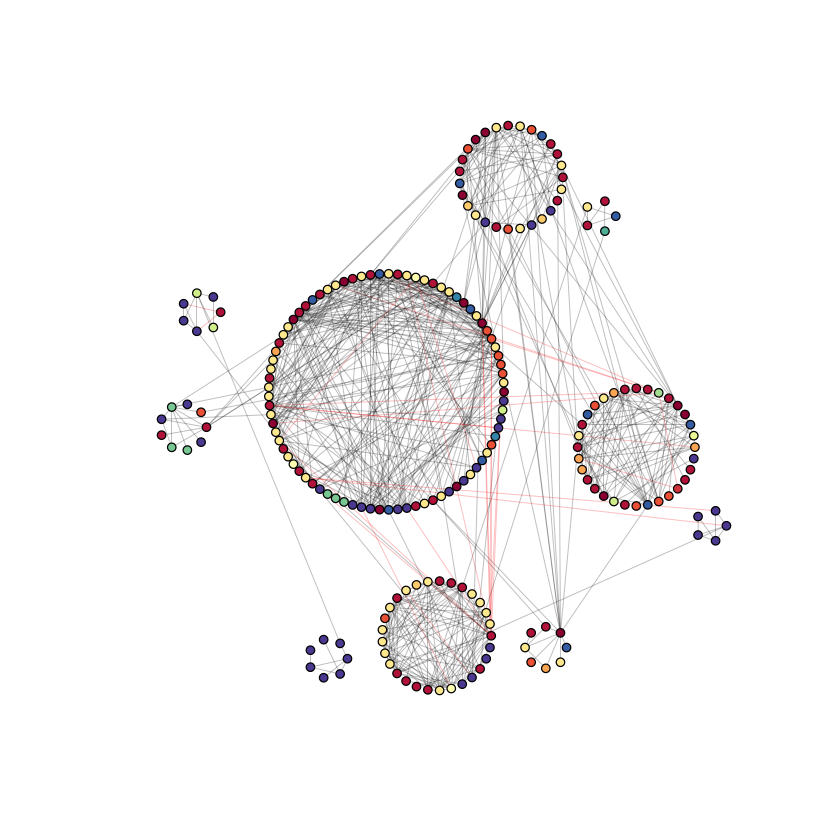

In [65]:
set.seed(7) # for .o 3, 5, 7
# set.seed(7) # for .m 3, 5, 7
#set.seed(42) # for .om 25, 29, 42 good, 36 ok

igraph.modules = list()

for (i in 1:length(AbundMods)){
    Mod = AbundMods[i]
    igraph.modules[[i]] = induced_subgraph(graph=igraph, v=c(Modules[[Mod]]))
}

graphs = igraph.modules

layouts = lapply(graphs,layout_in_circle)
lay = merge_coords(graphs, layouts)
g = disjoint_union(graphs)
layOrder = data.frame(lay)
layOrder$OTU = V(g)$name
layOrder$OTU = factor(layOrder$OTU, levels = V(igraph)$name)
layOrder = layOrder%>%
arrange(OTU)
lay = as.matrix(layOrder[,1:2])
igraph$layout = lay

options(repr.plot.width=7, repr.plot.height=7)

plot.igraph(induced_subgraph(igraph,vids=V(g)$name), vertex.size=3, vertex.label=NA,
    edge.width=c(0.2),edge.alpha=c(0.1)
    )

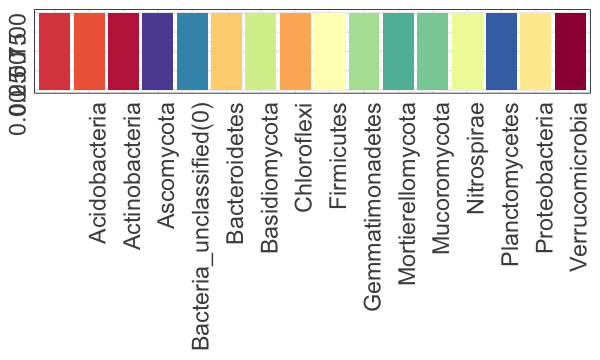

In [66]:
# For generating phylum legend
PhyCol = data.frame(V(igraph)$color,node_list$Phylum)
colnames(PhyCol) = c("Color","Phylum")
PhyCol = PhyCol %>%
    group_by(Color,Phylum)%>%
    summarize()%>%
    arrange(Phylum)
PhyCol$Color = ordered(as.factor(PhyCol$Color),levels=PhyCol$Color)

options(repr.plot.width=5, repr.plot.height=3)
rhg_cols <- PhyCol$Color
 qplot(PhyCol$Phylum, fill = rhg_cols) +
   scale_fill_identity() + theme_bw() + 
    theme(axis.text = element_text(angle=90,hjust=1,size=14),
         axis.title  = element_blank(),
         axis.ticks = element_blank())

In [67]:
# Interested in looking at various module properties, such as fraction that are fire responders

ModProps = node_list.om%>%
    filter(Module %in% AbundMods.om)%>%
    filter(Kingdom != "Plantae") %>%
    group_by(Module,FireResponseColor,Kingdom)%>%
    summarize(Total=n())%>%
    group_by(Module)%>%
    summarize(FullTotal=sum(Total), BactTotal = sum(Total[Kingdom=="Bacteria"]), FungTotal = sum(Total[Kingdom=="Fungi"|Kingdom==""]), PlantTotal = sum(Total[Kingdom=="Plantae"]),Fire = sum(Total[FireResponseColor=="red"]), NoFire = sum(Total[FireResponseColor=="blue"]))%>%
    mutate(FractFire = Fire/FullTotal,FractNoFire = NoFire/FullTotal)
ModProps


ModProps = node_list.om%>%
    filter(Module %in% AbundMods.om) %>%
    filter(Kingdom=="Fungi"|Kingdom=="")%>%
    group_by(Module,Trophic.Mode)%>%
    summarize(Total=n())%>%
    summarize(FullTotal=sum(Total), SaproTotal = sum(Total[Trophic.Mode=="Saprotroph"]))%>%
    mutate(FractSap = SaproTotal/FullTotal)
ModProps

Module,FullTotal,BactTotal,FungTotal,PlantTotal,Fire,NoFire,FractFire,FractNoFire
1,83,63,20,0,46,2,0.554216867,0.02409639
3,103,51,52,0,12,28,0.116504854,0.27184466
4,135,92,43,0,1,86,0.007407407,0.63703704
5,34,6,28,0,4,0,0.117647059,0.00000000
8,5,0,5,0,0,0,0.000000000,0.00000000
10,53,38,15,0,2,15,0.037735849,0.28301887
11,111,71,40,0,92,0,0.828828829,0.00000000
21,8,0,8,0,0,1,0.000000000,0.12500000


Module,FullTotal,SaproTotal,FractSap
1,20,7,0.3500000
3,52,22,0.4230769
4,43,14,0.3255814
5,28,8,0.2857143
8,5,5,1.0000000
10,15,6,0.4000000
11,40,6,0.1500000
21,8,1,0.1250000


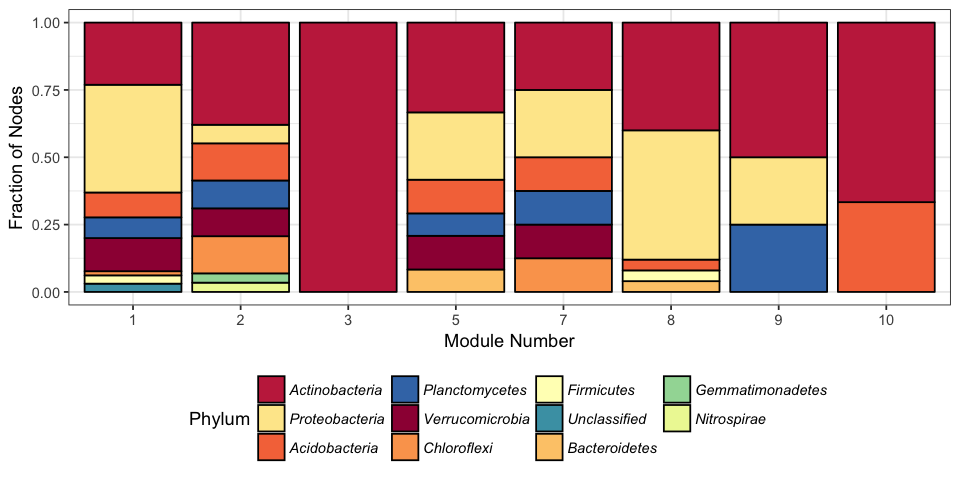

In [68]:
options(repr.plot.width=8, repr.plot.height=4)

# Plot phylogenetic fractions of bacterial nodes across most abundant modules

p = ggplot(ModProps.bact,aes(x=Module,y=Fract,fill=Phylum))
p = p + geom_bar(stat="identity",color="black")
p = p + theme_bw()
rbPal = colorRampPalette(brewer.pal(11,"Spectral"))
rbPal = rbPal(15)
#rbPal = rbPal(17)
#p = p + scale_fill_manual(values=c(rbPal,"white")[c(1,14,9,6,13,4,7,5,8,11)]) # For .o
p = p + scale_fill_manual(values=c(rbPal,"white")[c(2,7,4,14,1,5,8,13,6,11,9)]) # For .m
#p = p + scale_fill_manual(values=c(rbPal,"white")[c(1,8,5,6,16,7,3,10,2,12,11)]) # For .om
# Colours designed to match to network figure
p = p + theme(legend.position="bottom")
p = p + ylab("Fraction of Nodes") + xlab("Module Number")
p = p + theme(legend.text = element_text(face = "italic"))
p

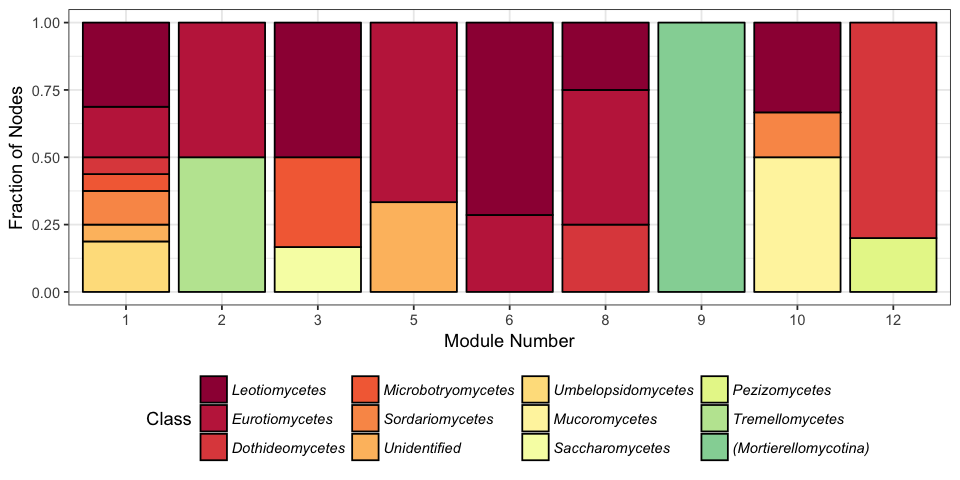

In [69]:
options(repr.plot.width=8, repr.plot.height=4)

# Plot phylogenetic fractions of fungal nodes across most abundant modules

p = ggplot(ModProps.fung,aes(x=Module,y=Fract,fill=Class))
p = p + geom_bar(stat="identity",color="black")
p = p + theme_bw()
p = p + theme(legend.text = element_text(face = "italic"))
p = p + theme(legend.position="bottom")
p = p + ylab("Fraction of Nodes") + xlab("Module Number")
rbPal = colorRampPalette(brewer.pal(11,"Spectral"))
rbPal = rbPal(16)
p = p + scale_fill_manual(values=rbPal)
p

### How abundant are taxa from each module, across the different samples?

In [70]:
# Pull in the original phyloseq objects and get normalized counts

# Fungi
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
mdf.f = psmelt(ps.norm)
                                  
mdf2.f = mdf.f %>%
mutate(OTU=paste("F",OTU,sep=""))%>%
filter(OTU %in% node_list$OTU)
# Get only network OTUs, change naming scheme to match node_list
M.f = node_list[,c("OTU","Module")]
# Get just the two relevant columns
mdf2.f = merge(mdf2.f,M.f,by="OTU",all.x=TRUE)
# Merge the two dataframes
                  
# Bacteria
ps = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
ps.norm = transform_sample_counts(ps, function(x) x/sum(x))
mdf.b = psmelt(ps.norm)
                                  
mdf2.b = mdf.b %>%
mutate(OTU=paste("B",OTU,sep=""))%>%
filter(OTU %in% node_list$OTU)
# Get only network OTUs, change naming scheme to match node_list
M.b = node_list[,c("OTU","Module")]
# Get just the two relevant columns
mdf2.b = merge(mdf2.b,M.b,by="OTU",all.x=TRUE)
# Merge the two dataframes

In [71]:
# Grouping by pH, total C, etc.
OTUbyMod.f = mdf2.f %>%
    group_by(Sample,Module,CBI,pH,Org_or_Min,Moisture_Regime,Veg_Comm,Land_Class,Severity_Class,TC_pct,Kingdom)%>%
    summarize(Abundance = sum(Abundance))%>%
    mutate(ModuleName = paste("Module",Module))%>%
    mutate(pHGroup = ifelse(pH>7,">7",
                          ifelse(pH>5,"5-7","<5")))%>%
    mutate(OMGroup = ifelse(TC_pct>35,">35",
                          ifelse(TC_pct>5,"5-35",
                                ifelse(TC_pct>2,"2-5","<2"))))
OTUbyMod.f$pHGroup = factor(OTUbyMod.f$pHGroup, levels = c("<5", "5-7", ">7"))
OTUbyMod.f$OMGroup = factor(OTUbyMod.f$OMGroup, levels = c("<2", "2-5","5-35",">35"))

OTUbyMod.b = mdf2.b %>%
    group_by(Sample,Module,CBI,pH,Org_or_Min,Moisture_Regime,Veg_Comm,Land_Class,Severity_Class,TC_pct,Kingdom)%>%
    summarize(Abundance = sum(Abundance))%>%
    mutate(ModuleName = paste("Module",Module))%>%
    mutate(pHGroup = ifelse(pH>7,">7",
                      ifelse(pH>5,"5-7","<5")))%>%
    mutate(OMGroup = ifelse(TC_pct>35,">35",
                          ifelse(TC_pct>5,"5-35",
                                ifelse(TC_pct>2,"2-5","<2"))))
OTUbyMod.b$pHGroup = factor(OTUbyMod.b$pHGroup, levels = c("<5", "5-7", ">7"))
OTUbyMod.b$OMGroup = factor(OTUbyMod.b$OMGroup, levels = c("<2", "2-5","5-35",">35"))

OTUbyMod.f$Kingdom = "ITS2"
OTUbyMod.b$Kingdom = "16S"

In [72]:
AbundMods

[1]  1  2  8  5 10  7  3  6  9 12

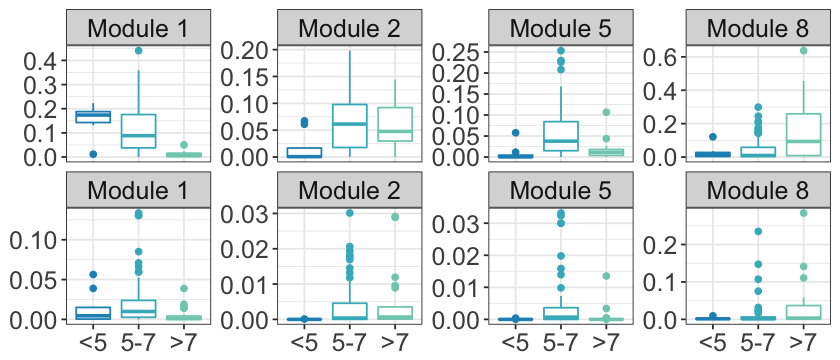

In [73]:
# Plotting abundance of fungi and bacteria from each module across different pH groupings

options(repr.plot.width=7, repr.plot.height=3)

plotmods.om = c(1,4,5,11)
plotmods.o = c(1,2,3,5)
plotmods.m = c(1,2,5,8)

d = rbind(OTUbyMod.f,OTUbyMod.b) %>%
    filter(Module %in% plotmods.m)%>%
    filter(!is.na(pHGroup))%>%
    mutate(StripName = paste(Kingdom,Module))

Labeller = as_labeller(c('16S 1'="Module 1",
    '16S 2'="Module 2",
     '16S 3'="Module 3",
    '16S 4'="Module 4",
     '16S 5'="Module 5",
    '16S 6'="Module 6",
    '16S 7'="Module 7",
    '16S 8'="Module 8",
    '16S 9'="Module 9",
     '16S 10'="Module 10",
    '16S 11'="Module 11",
    '16S 12'="Module 12",
    '16S 18'="Module 18",
    '16S 21'= "Module 21",
     'ITS2 1'="Module 1",
    'ITS2 2'="Module 2",
     'ITS2 3'="Module 3",
    'ITS2 4'="Module 4",
     'ITS2 5'="Module 5",
    'ITS2 6'="Module 6",
    'ITS2 7'="Module 7",
    'ITS2 8'="Module 8",
    'ITS2 9'="Module 9",
     'ITS2 10'= "Module 10",
    'ITS2 11'= "Module 11",
    'ITS2 12'= "Module 12",
    'ITS2 18'= "Module 18",
    'ITS2 21'= "Module 21"))

p = ggplot(data=d, aes(x=pHGroup,y=Abundance,color=pHGroup))
p = p + geom_boxplot()
p = p + theme_bw()
palette = (brewer.pal(9, "YlGnBu")[3:9])[c(4,3,2)]
p = p + scale_color_manual(values=palette)
p = p + facet_wrap(~StripName, scales="free_y",ncol=4,labeller=Labeller) + expand_limits(y=0)
p = p + ylab("Relative Abundance") + xlab("pH range") + guides(color = "none")
p = p + theme(axis.text=element_text(size=15),
             axis.title=element_blank(),
             strip.text=element_text(size=15))
p

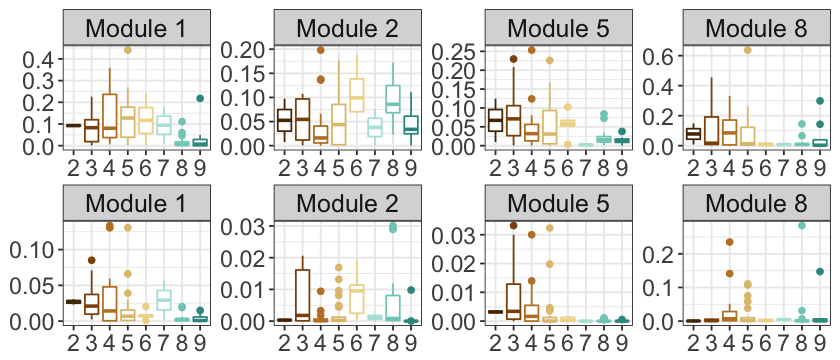

In [74]:
# Plotting abundance of fungi and bacteria from each module across different moisture classes

options(repr.plot.width=7, repr.plot.height=3)
d = rbind(OTUbyMod.f,OTUbyMod.b) %>%
    filter(Module %in% plotmods.m)%>%
    filter(!is.na(pHGroup))%>%
    mutate(StripName = paste(Kingdom,Module))

Labeller = as_labeller(c('16S 1'="Module 1",
    '16S 2'="Module 2",
     '16S 3'="Module 3",
    '16S 4'="Module 4",
     '16S 5'="Module 5",
    '16S 6'="Module 6",
    '16S 7'="Module 7",
    '16S 8'="Module 8",
    '16S 9'="Module 9",
     '16S 10'="Module 10",
    '16S 11'="Module 11",
    '16S 12'="Module 12",
    '16S 18'="Module 18",
    '16S 21'= "Module 21",
     'ITS2 1'="Module 1",
    'ITS2 2'="Module 2",
     'ITS2 3'="Module 3",
    'ITS2 4'="Module 4",
     'ITS2 5'="Module 5",
    'ITS2 6'="Module 6",
    'ITS2 7'="Module 7",
    'ITS2 8'="Module 8",
    'ITS2 9'="Module 9",
     'ITS2 10'= "Module 10",
    'ITS2 11'= "Module 11",
    'ITS2 12'= "Module 12",
    'ITS2 18'= "Module 18",
    'ITS2 21'= "Module 21"))

p = ggplot(data=d, aes(x=Moisture_Regime,y=Abundance,color=Moisture_Regime))
p = p + geom_boxplot()
p = p + theme_bw()
palette = c(brewer.pal(9,"Spectral")[c(1,2,3,4,7:9)],"#421C52")
palette = c('#543005','#8c510a','#bf812d','#dfc27d','#efd797','#b4e3dc','#80cdc1','#35978f','#01665e','#003c30')
p = p + scale_color_manual(values=palette)
p = p + facet_wrap(~StripName, scales="free", ncol=4,labeller=Labeller) + expand_limits(y=0)
p = p + ylab("Relative Abundance") + xlab("Moisture Regime") + guides(color = "none")
p = p + theme(axis.text=element_text(size=14),
             axis.title=element_blank(),
             strip.text=element_text(size=15))
p